# Equity Apartments Trust Price Prediction

In [14]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from optuna import visualization as vis
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [5]:
# Load the data
df = pd.read_csv('../data/final_data.csv')
# sort by date
df = df.sort_values(by='date')
df

,date,State,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
0,2016-12-30,AL,43.000000,-0.556701,52.000000,-0.174603,3.000000,-0.571429,36.000000,0.161290,...,37.555556,-11.831541,1994.000000,-0.005982,0.962797,-0.005236,99.543540,0.022577,1122.650058,216066.470760
22,2016-12-30,NM,114.313585,0.084512,134.713228,0.382836,20.912155,0.233377,49.089377,-0.202766,...,34.912703,3.409213,1581.070352,0.000619,0.968729,-0.003238,123.185945,-0.022682,1000.213260,214940.891096
23,2016-12-30,NV,73.000000,-0.401639,119.000000,-0.201342,11.000000,-0.312500,85.000000,-0.174757,...,22.976471,4.889092,1534.000000,0.009875,0.975629,-0.001425,171.276080,0.051403,1148.605311,305904.466295
24,2016-12-30,NY,151.742276,-0.169707,92.002294,-0.282131,3.498929,0.101171,96.855613,-0.176365,...,33.720803,2.649503,1349.549098,-0.060022,0.969925,0.004392,328.973719,0.029551,1895.798229,456494.835558
25,2016-12-30,OH,148.807790,-0.110787,141.400560,-0.119257,8.218554,0.395212,89.297186,-0.161583,...,30.830572,-0.016809,1560.083967,0.006244,0.960467,0.020897,76.917214,0.094313,843.742553,129419.574891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18425,2024-11-01,MA,97.090933,-0.041412,108.639851,0.122470,22.133546,0.093218,94.045135,0.329857,...,12.019740,-2.424043,1628.974114,0.013848,1.001044,-0.003737,407.260117,0.051139,2594.192374,625927.096790
18426,2024-11-01,MD,95.834211,0.211162,108.185107,0.159219,27.503864,0.048320,85.445557,0.262958,...,12.788671,-0.572449,1767.211363,-0.016668,0.998137,0.001047,221.888798,0.042522,1943.986460,396332.990533
18427,2024-11-01,ME,34.411858,0.313887,39.709881,0.830392,6.226087,0.024200,26.207115,0.097976,...,15.972631,3.528026,1569.513439,0.029284,0.975217,-0.004498,184.368299,0.006300,1536.475750,299791.577634
18416,2024-11-01,GA,25.704628,-0.165583,28.377602,-0.020919,5.882505,0.030047,21.229142,0.355209,...,21.932300,-0.595328,1743.028643,-0.022036,0.970562,-0.001474,159.285000,0.115485,1541.986132,255540.577007


In [6]:
# describe the data
df.describe()

,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,median_new_listing_price_yoy,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
count,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,...,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000,18456.000000
mean,224.822185,0.020352,228.979772,0.016517,57.717817,0.265805,190.655146,0.017660,356879.316094,0.077466,...,13.636546,-0.454951,1740.661655,0.010256,0.991642,0.001699,206.673428,0.078572,1515.914613,338363.084043
std,268.399737,0.252885,277.258932,0.293648,75.809862,1.074286,226.218136,0.258654,145058.128008,0.088239,...,6.712299,5.333714,239.320561,0.071756,0.018139,0.014420,117.353164,0.077867,419.397500,147694.948987
min,4.000000,-0.846920,6.000000,-0.911950,0.000000,-1.000000,5.871287,-0.840433,73450.000000,-0.680511,...,2.360043,-92.758503,814.000000,-0.387527,0.900450,-0.089645,55.159332,-0.468836,698.509937,84040.300712
25%,78.000000,-0.109911,82.000000,-0.119166,15.700872,-0.165918,70.003369,-0.130728,255538.988678,0.028102,...,8.962673,-2.758122,1595.991905,-0.024072,0.979629,-0.004696,135.614105,0.031558,1212.348959,229266.392067
50%,147.000227,0.005099,152.890582,-0.011288,32.076813,0.069249,127.582461,-0.007770,316702.743756,0.068650,...,12.272461,-0.297261,1732.524705,0.006440,0.989610,0.001766,169.675033,0.068387,1433.380442,299045.004648
75%,237.769617,0.111253,238.005492,0.104181,66.831753,0.412722,202.562952,0.115053,425760.055916,0.118067,...,16.750018,1.906682,1875.542798,0.039469,1.001578,0.008937,230.560699,0.116866,1757.839478,404140.550752
max,1938.274806,7.306175,2068.905801,13.941223,900.482199,55.000000,2069.351800,3.762365,997500.000000,1.118367,...,117.757692,94.271909,2879.872908,1.105556,1.090251,0.088707,829.763339,1.262682,2910.561059,923341.979821


### Regional Filter

In [7]:
# include only rows where state is within California, Colorado, Connecticut, DC, Florida, Maryland, Mass, New Jersey, New York, North Carolina, Texas, Virginia, Washington
df = df[(df['State'] == 'CA') | (df['State'] == 'CO') | (df['State'] == 'DC') | (df['State'] == 'MA') | (
        df['State'] == 'NY') | (df['State'] == 'WA')]
df

,date,State,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
24,2016-12-30,NY,151.742276,-0.169707,92.002294,-0.282131,3.498929,0.101171,96.855613,-0.176365,...,33.720803,2.649503,1349.549098,-0.060022,0.969925,0.004392,328.973719,0.029551,1895.798229,456494.835558
36,2016-12-30,WA,204.418965,-0.207611,212.651097,-0.244751,59.000302,-0.007422,178.338031,-0.062777,...,12.728302,-0.133441,1764.748440,0.005044,1.000935,0.008768,198.389570,0.128863,1353.784035,349653.898163
3,2016-12-30,CA,612.258489,-0.166035,494.876903,-0.161775,51.993744,-0.202137,449.127889,-0.100053,...,16.392470,1.228898,1565.083335,0.005876,0.987203,0.000618,281.519117,0.052298,1733.103784,424866.748029
4,2016-12-30,CO,116.748688,-0.142112,113.713386,-0.122118,28.049738,0.623202,90.909974,-0.055629,...,15.428519,-1.889838,2021.811483,0.068551,0.989235,-0.001155,162.279162,0.084925,1356.071288,337328.649093
5,2016-12-30,DC,171.000000,-0.044693,126.000000,-0.059701,19.000000,-0.472222,124.000000,-0.107914,...,11.588710,1.394465,1086.000000,-0.174144,1.003606,0.021006,464.101620,0.169856,2035.593059,513690.678929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18452,2024-11-01,WA,156.067062,0.103779,206.177883,0.143892,65.596130,0.229365,202.261453,0.301700,...,13.174977,-0.520094,1828.096801,0.041181,0.992876,0.003316,376.619631,0.054799,1974.242008,625140.177926
18410,2024-11-01,CA,485.363465,-0.014643,438.143763,0.051820,78.583198,-0.061486,409.294958,0.375200,...,15.506285,-1.907167,1629.691293,0.019704,0.996406,-0.003339,476.271513,0.031950,2647.937095,753402.067886
18411,2024-11-01,CO,95.583021,-0.122014,129.962599,0.141787,16.703387,0.070053,108.415986,0.368317,...,18.808834,-1.775119,2079.424344,0.108283,0.980707,0.001308,332.639221,0.053223,2288.342408,590639.295058
18413,2024-11-01,DC,188.000000,0.392593,170.000000,0.205674,11.000000,-0.576923,114.000000,0.187500,...,26.640351,0.348684,1371.500000,-0.085667,0.987483,-0.002573,489.004385,-0.043402,2520.749001,602763.948227


### Aggregate Rows by Date

In [8]:
df = utils.process_data(df.drop(columns='State'), utils.features_weighted, groupby='date')
df

,date,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
0,2016-12-30,426.750393,-0.162737,346.635046,-0.186138,41.217969,-0.058406,314.001316,-0.104653,437912.411911,...,18.317896,0.836410,1583.289473,-0.001599,0.986028,0.002547,266.823204,0.062113,1676.681996,410095.137865
1,2017-01-06,514.622987,-0.056746,462.675962,-0.088444,90.222193,0.007176,382.031795,0.022868,438478.830942,...,14.346146,-1.572309,1576.387424,0.016473,0.985284,0.003240,271.763984,0.090351,1680.522541,414477.750108
2,2017-01-13,482.547548,-0.036794,488.751404,0.000238,114.627752,0.124496,330.004917,0.094829,444002.701797,...,16.989561,-2.865483,1593.976798,0.014398,0.984053,0.001278,266.223404,0.078999,1669.345386,411548.521474
3,2017-01-20,477.944547,-0.027232,497.221581,-0.088102,110.605881,0.168165,353.432620,-0.154790,459291.410393,...,16.208286,1.122910,1593.658058,0.016812,0.985843,0.003522,263.667077,0.088752,1695.821479,419692.558814
4,2017-01-27,551.138359,-0.012793,539.438213,0.008837,129.264554,0.208939,406.563286,0.393411,472513.516942,...,13.575256,-6.525796,1583.990313,-0.022375,0.985436,0.002497,272.160821,0.088665,1711.696305,427212.377375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2024-10-04,382.532630,0.105904,338.513449,0.205168,63.778033,0.999517,274.351958,0.187074,733017.766794,...,16.916471,0.332584,1685.464176,0.019456,0.996360,-0.003163,474.722632,0.049177,2556.382112,702853.064957
406,2024-10-11,368.212842,0.094253,325.634022,0.136880,64.379384,0.247223,259.874136,0.000060,737639.595902,...,18.063496,3.357058,1672.086162,0.019034,0.997074,-0.002523,461.427606,0.028697,2556.457078,702011.579112
407,2024-10-18,342.271209,0.092552,322.501253,0.147292,62.246501,0.146192,294.862937,0.112067,735964.727595,...,15.960001,1.175175,1678.840153,0.035062,0.995863,-0.001722,464.590138,0.029733,2560.228953,704960.654387
408,2024-10-25,306.243546,-0.008846,314.265931,0.138411,62.780487,0.087798,317.518368,0.159057,723690.734183,...,14.188741,0.345061,1680.644697,0.019092,0.994800,-0.001199,460.858122,0.030300,2530.508370,697751.217738


### Add AlphaVantage Data

In [9]:
#Read alpha vantage data
file_path_av = "../data/av_data.csv"
df_av = pd.read_csv(file_path_av)
df_av = df_av.drop(columns=['Unnamed: 0'])
df_av

,date,SPY_adj_close,SPY_return_1day,SPY_return_1week,SPY_return_1month,SPY_return_3month,EQR_adj_close,EQR_adj_close_1day,EQR_adj_close_1week,EQR_adj_close_1month,...,AVB_adj_close_3month,INVH_adj_close,INVH_adj_close_1day,INVH_adj_close_1week,INVH_adj_close_1month,INVH_adj_close_3month,unemployment,fed_funds,3monhth_treasury_yield,cpi
0,2017-02-03,201.410539,-0.001788,0.009462,0.036496,0.045656,45.852975,45.989668,47.030055,47.402165,...,148.539775,17.272979,17.356707,17.599516,18.353064,18.018154,0.047,0.000098,0.0065,2.42839
1,2017-02-10,203.316271,0.005443,0.015464,0.027213,0.038761,47.030055,47.189531,46.764263,47.516076,...,149.262275,17.599516,17.582771,17.708362,17.900935,17.959545,0.046,0.000104,0.0066,2.43603
2,2017-02-17,206.460293,0.005955,0.008592,0.011536,0.025677,46.764263,47.402165,48.040066,47.986908,...,149.238969,17.708362,17.976290,18.260964,18.034899,17.941583,0.046,0.000102,0.0066,2.43603
3,2017-02-24,207.909361,0.001563,0.007096,-0.007860,0.016153,47.675551,48.040066,47.326224,48.178335,...,149.137974,18.085136,18.260964,18.260964,18.068390,18.193454,0.046,0.000100,0.0066,2.43603
4,2017-03-03,209.384761,-0.002978,-0.003062,-0.006931,0.017333,47.326224,47.402165,47.052837,47.627201,...,148.633001,18.260964,18.353064,17.917681,18.277709,17.933188,0.046,0.000117,0.0065,2.43603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2024-08-16,552.612504,0.009561,0.014108,0.015389,0.083508,70.775391,70.953791,72.975662,77.078870,...,232.210000,35.000079,35.347302,35.863177,36.478257,33.830000,0.042,0.000999,0.0533,3.14796
382,2024-08-23,560.408556,-0.002384,0.002757,0.016526,0.049502,72.975662,72.281883,74.214553,76.751803,...,229.220000,35.863177,35.545716,36.547702,36.210400,34.150000,0.042,0.000990,0.0533,3.14796
383,2024-08-30,561.953809,-0.020579,-0.030638,0.021009,0.063308,74.214553,74.987622,74.432598,74.460000,...,232.900000,36.547702,36.974290,35.406826,35.260000,33.840000,0.042,0.000979,0.0533,3.14796
384,2024-09-06,538.705224,0.011196,0.040066,0.063624,0.120520,73.679352,74.432598,77.386115,73.530000,...,230.800000,35.664763,35.406826,36.726274,34.540000,33.900000,0.041,0.000968,0.0533,3.15301


In [10]:
df = pd.merge(df, df_av,
              on=["date"],
              how="left")
df.dropna(inplace=True)
df

,date,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,...,AVB_adj_close_3month,INVH_adj_close,INVH_adj_close_1day,INVH_adj_close_1week,INVH_adj_close_1month,INVH_adj_close_3month,unemployment,fed_funds,3monhth_treasury_yield,cpi
5,2017-02-03,548.772452,-0.046394,547.732738,-0.054225,139.120589,0.072120,323.218660,-0.018295,470406.760147,...,148.539775,17.272979,17.356707,17.599516,18.353064,18.018154,0.047,0.000098,0.0065,2.42839
6,2017-02-10,543.885113,-0.031627,584.136574,0.028103,143.491242,0.141865,401.217684,0.244176,470034.917067,...,149.262275,17.599516,17.582771,17.708362,17.900935,17.959545,0.046,0.000104,0.0066,2.43603
7,2017-02-17,540.158761,-0.084154,552.112960,-0.090483,134.317990,0.073751,359.615586,-0.135684,468865.864989,...,149.238969,17.708362,17.976290,18.260964,18.034899,17.941583,0.046,0.000102,0.0066,2.43603
8,2017-02-24,627.814169,-0.071756,597.987743,-0.039632,152.616311,0.576183,489.413106,0.135456,482414.109001,...,149.137974,18.085136,18.260964,18.260964,18.068390,18.193454,0.046,0.000100,0.0066,2.43603
9,2017-03-03,611.186201,0.007191,578.317472,-0.036050,155.094802,0.091772,399.432796,0.066991,532426.422988,...,148.633001,18.260964,18.353064,17.917681,18.277709,17.933188,0.046,0.000117,0.0065,2.43603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2024-08-16,376.803700,0.087944,331.746735,-0.038061,66.903375,0.613024,291.259358,-0.008890,716359.366070,...,232.210000,35.000079,35.347302,35.863177,36.478257,33.830000,0.042,0.000999,0.0533,3.14796
399,2024-08-23,318.465056,0.032335,346.746468,0.034682,66.259595,0.047036,354.645058,0.045073,718513.626398,...,229.220000,35.863177,35.545716,36.547702,36.210400,34.150000,0.042,0.000990,0.0533,3.14796
400,2024-08-30,421.869001,0.099688,292.078365,0.043316,54.520741,0.122183,235.190609,0.044457,732624.680741,...,232.900000,36.547702,36.974290,35.406826,35.260000,33.840000,0.042,0.000979,0.0533,3.14796
401,2024-09-06,424.796160,0.131145,332.823205,0.042387,66.586909,-0.047748,276.808245,-0.006505,740072.064514,...,230.800000,35.664763,35.406826,36.726274,34.540000,33.900000,0.041,0.000968,0.0533,3.15301


### Splitting Data

In [11]:
# Split the data into features and target
X = df.drop(columns=['date', 'EQR_adj_close_1day', 'ESS_adj_close_1day', 'AVB_adj_close_1day', 'INVH_adj_close_1day',
                     'EQR_adj_close_1week', 'ESS_adj_close_1week', 'AVB_adj_close_1week', 'INVH_adj_close_1week',
                     'EQR_adj_close', 'ESS_adj_close', 'AVB_adj_close', 'INVH_adj_close', 'EQR_adj_close_1month',
                     'ESS_adj_close_1month', 'AVB_adj_close_1month', 'INVH_adj_close_1month', 'EQR_adj_close_3month',
                     'ESS_adj_close_3month', 'AVB_adj_close_3month', 'INVH_adj_close_3month'])
y = df['EQR_adj_close_1week']

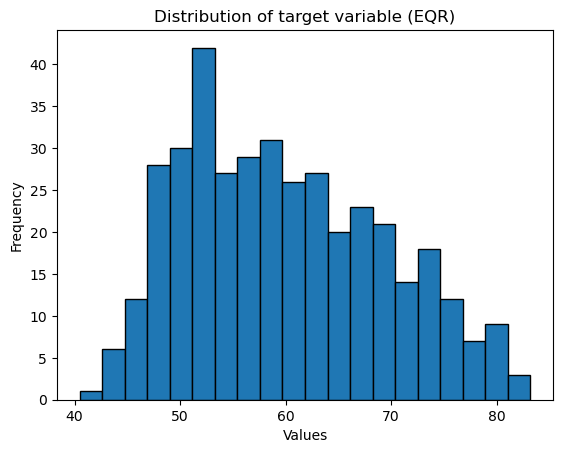

In [28]:
#target variable distribution
plt.hist(y, bins=20, edgecolor='black')
plt.title('Distribution of target variable (EQR)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

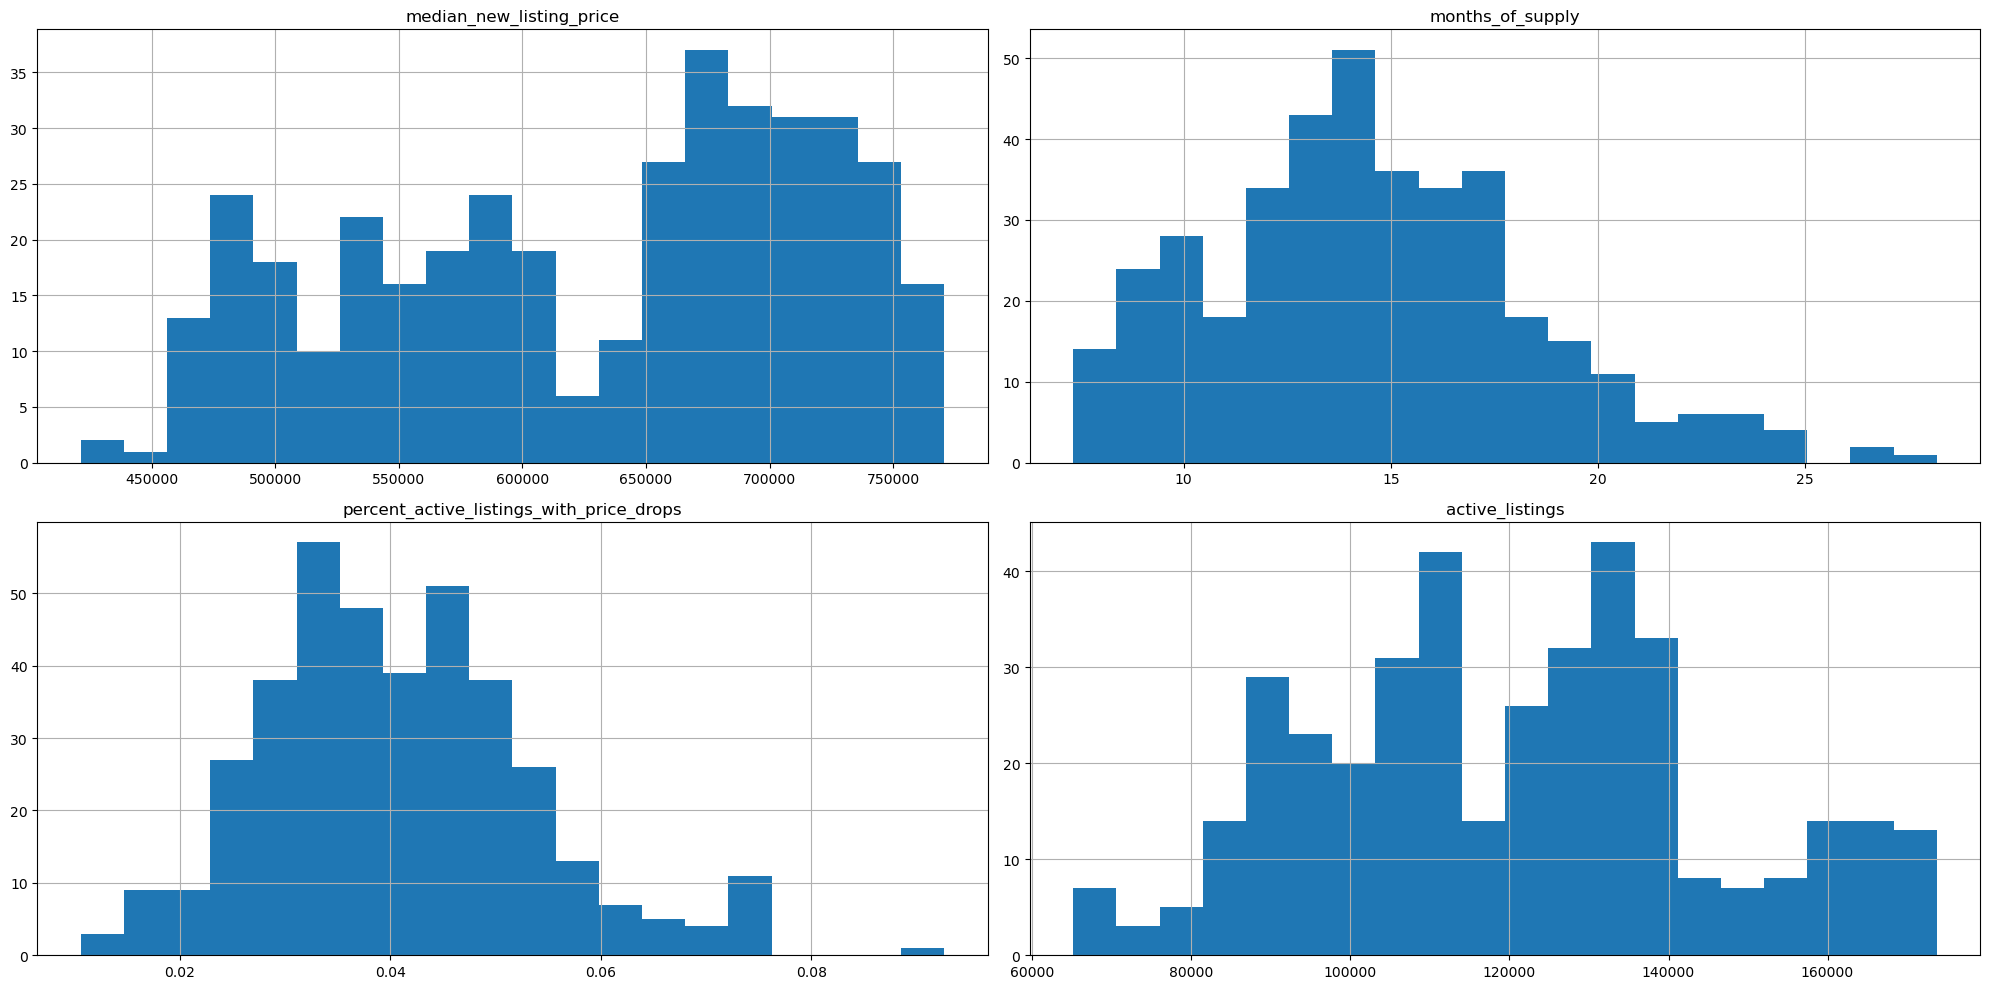

In [29]:
#feature distribution
selected_features = X[["median_new_listing_price", "months_of_supply","percent_active_listings_with_price_drops", "active_listings"]]
selected_features.hist(bins=20, figsize=(20, 10))
plt.tight_layout()
plt.show()

<Axes: >

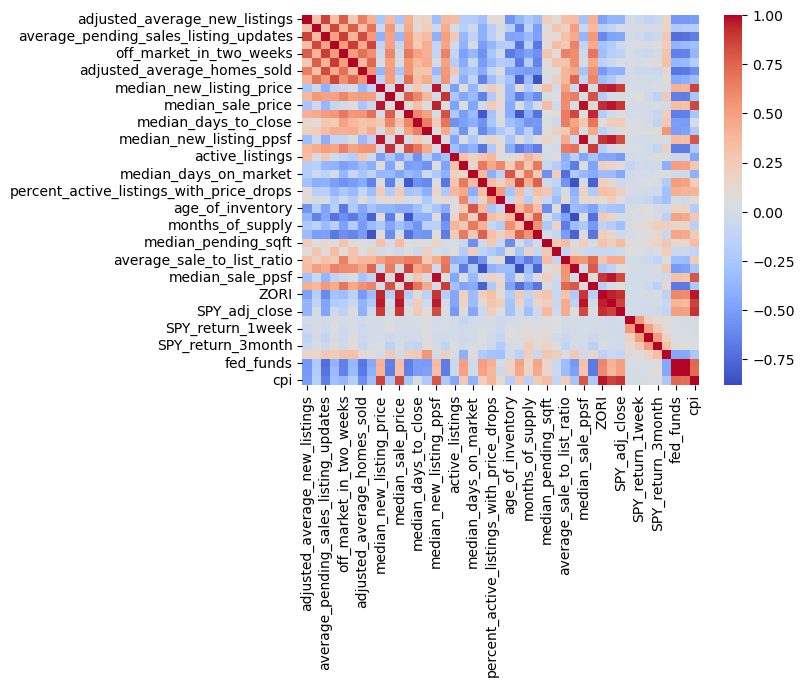

In [17]:
#Correlation
corr = X.corr()
sns.heatmap(corr, annot = False, cmap = "coolwarm")

### Train-Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)

## Modeling

In [31]:
# define scorer and cross-validation
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
cv = KFold(n_splits=20, shuffle=True, random_state=42)
n_trials = 15

### Random Forest

#### Hyperparameter Tuning

In [32]:
# Hyperparameter search space
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the Random Forest model with suggested hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    scores = cross_val_score(rf, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -np.mean(scores)

In [33]:
study_rf = optuna.create_study(direction='minimize', study_name='rf_tuning')
study_rf.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-11 18:32:42,646] A new study created in memory with name: rf_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-11 18:32:45,894] Trial 0 finished with value: 5.547287139529821 and parameters: {'n_estimators': 413, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 5.547287139529821.
[I 2024-12-11 18:32:49,043] Trial 1 finished with value: 2.8578460071992327 and parameters: {'n_estimators': 306, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 2.8578460071992327.
[I 2024-12-11 18:32:50,871] Trial 2 finished with value: 2.67450419944887 and parameters: {'n_estimators': 169, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: 2.67450419944887.
[I 2024-12-11 18:32:52,582] Trial 3 finished with value: 4.6401944963858766 and parameters: {'n_estimators': 281, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 2 with value: 2.67450419944887.
[I 2024-12-11

In [34]:
vis.plot_optimization_history(study_rf).show()
vis.plot_param_importances(study_rf).show()

#### Model Training

In [35]:
# Get the best hyperparameters
best_params_rf = study_rf.best_params

In [36]:
# Create the Random Forest model with best hyperparameters
rf = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)

In [37]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features='log2', min_samples_split=5,
                      n_estimators=497, random_state=42)

#### Model Evaluation

In [38]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

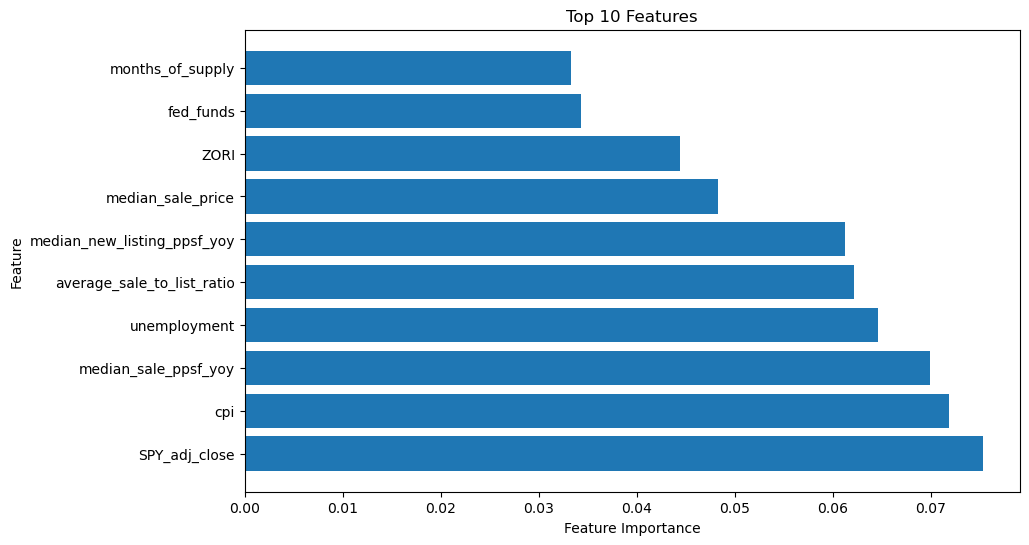

In [39]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(rf.feature_importances_)[::-1][:10]],
         rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

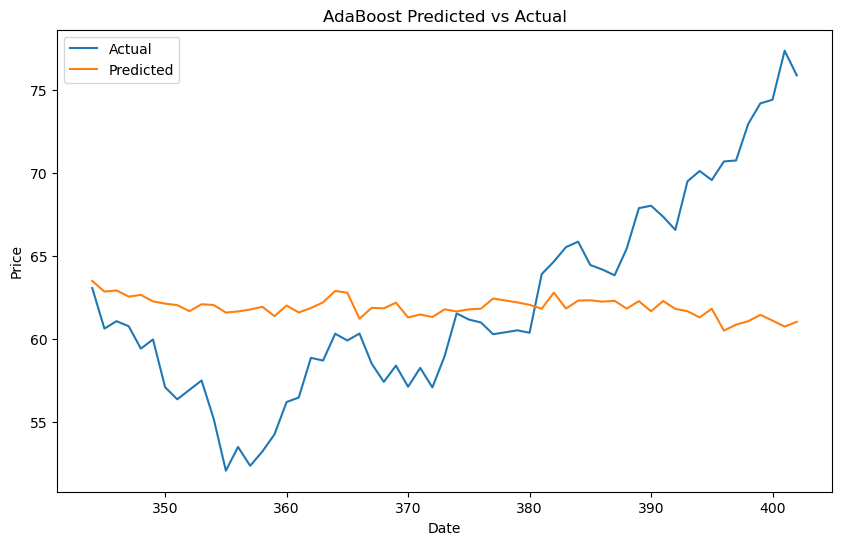

In [66]:
# show predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf_test, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AdaBoost Predicted vs Actual')
plt.legend()
plt.show()

#### Model Saving

In [40]:
# Save the model
pickle.dump(rf, open('../models/EQR_rf.pkl', 'wb'))

### AdaBoost

#### Hyperparameter Tuning

In [41]:
def objective(trial):
    # Hyperparameter search space for the base Decision Tree
    max_depth = trial.suggest_int('max_depth', 1, 2)  # Depth of the tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split a node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Minimum samples in a leaf node
    max_features = trial.suggest_categorical('max_features',
                                             [None, 'sqrt', 'log2'])  # Features to consider for splitting

    # Hyperparameter search space for AdaBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    # Define the base estimator (Decision Tree)
    base_estimator = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Define the AdaBoost model
    model = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -scores.mean()

In [42]:
# Optimize hyperparameters
study_ada = optuna.create_study(direction='minimize', study_name='ada_tuning')
study_ada.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-11 18:33:07,050] A new study created in memory with name: ada_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-11 18:33:07,239] Trial 0 finished with value: 7.3395504772814135 and parameters: {'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'n_estimators': 169, 'learning_rate': 0.23178898534202255}. Best is trial 0 with value: 7.3395504772814135.
[I 2024-12-11 18:33:07,723] Trial 1 finished with value: 7.312790583836721 and parameters: {'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'n_estimators': 154, 'learning_rate': 0.010075238391226699}. Best is trial 1 with value: 7.312790583836721.
[I 2024-12-11 18:33:08,276] Trial 2 finished with value: 7.205175744408665 and parameters: {'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'n_estimators': 161, 'learning_rate': 0.03341919582985652}. Best is trial 2 with value: 7.205175744408665.
[I 2024-12-11 18:33:09,781] Trial 3 finished with value: 4.394406070867282 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_

In [43]:
# Visualizations
vis.plot_optimization_history(study_ada).show()
vis.plot_param_importances(study_ada).show()

#### Model Training

In [44]:
# Get the best hyperparameters
best_params_ada = study_ada.best_params

In [45]:
# Create the AdaBoost model with best hyperparameters
dt = DecisionTreeRegressor(
    max_depth=best_params_ada['max_depth'],
    min_samples_split=best_params_ada['min_samples_split'],
    min_samples_leaf=best_params_ada['min_samples_leaf'],
    max_features=best_params_ada['max_features'],
    random_state=42
)

ab = AdaBoostRegressor(
    estimator=dt,
    n_estimators=best_params_ada['n_estimators'],
    learning_rate=best_params_ada['learning_rate'],
    random_state=42
)

In [46]:
# Fit the model
ab.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=2,
                                                  max_features='sqrt',
                                                  min_samples_leaf=6,
                                                  min_samples_split=3,
                                                  random_state=42),
                  learning_rate=0.438127723216328, n_estimators=409,
                  random_state=42)

#### Model Evaluation

In [47]:
y_pred_ada_train = ab.predict(X_train)
y_pred_ada_test = ab.predict(X_test)

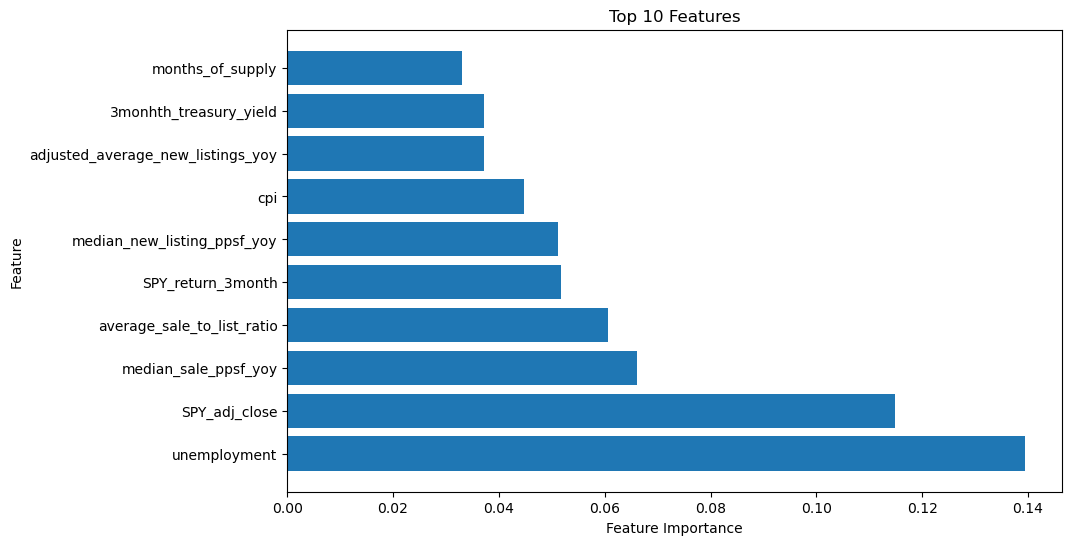

In [48]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(ab.feature_importances_)[::-1][:10]],
         ab.feature_importances_[np.argsort(ab.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

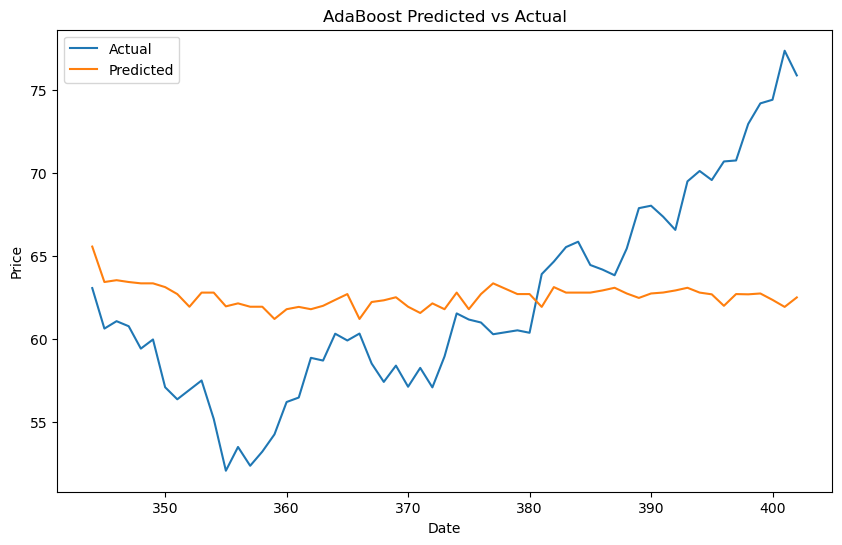

In [49]:
# show predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_ada_test, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AdaBoost Predicted vs Actual')
plt.legend()
plt.show()

#### Model Saving

In [50]:
# Save the model
pickle.dump(ab, open('../models/EQR_ada.pkl', 'wb'))

### XGBoost

#### Hyperparameter Tuning

In [51]:
# Hyperparameter search space
def objective(trial):
    # Define the hyperparameter search space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),  # L2 regularization
    }

    # Initialize XGBoost model
    model = XGBRegressor(random_state=42, **param)

    scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -scores.mean()

In [52]:
# Optimize hyperparameters
study_xg = optuna.create_study(direction='minimize', study_name='xg_tuning')
study_xg.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-11 18:33:19,811] A new study created in memory with name: xg_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-11 18:33:21,230] Trial 0 finished with value: 6.049600984273538 and parameters: {'n_estimators': 336, 'max_depth': 4, 'learning_rate': 0.001946151486863181, 'subsample': 0.7751686893002665, 'colsample_bytree': 0.7650110316506589, 'gamma': 4.104223570973428, 'min_child_weight': 3, 'reg_alpha': 0.5949023876530287, 'reg_lambda': 2.8969894704312122}. Best is trial 0 with value: 6.049600984273538.
[I 2024-12-11 18:33:22,489] Trial 1 finished with value: 2.3034600266797183 and parameters: {'n_estimators': 553, 'max_depth': 3, 'learning_rate': 0.014067705598392356, 'subsample': 0.5389438874673977, 'colsample_bytree': 0.7492063589456327, 'gamma': 1.2855750198964466, 'min_child_weight': 8, 'reg_alpha': 0.41401114556565766, 'reg_lambda': 1.180318516207589}. Best is trial 1 with value: 2.3034600266797183.
[I 2024-12-11 18:33:24,546] Trial 2 finished with value: 2.2558665869675254 and parameters: {'n_estimators': 830, 'max_depth': 5, 'learning_rate': 0.009208945712275308, 'subsample': 0

In [53]:
# Visualizations
vis.plot_optimization_history(study_xg).show()
vis.plot_param_importances(study_xg).show()

#### Model Training

In [54]:
# Get the best hyperparameters
best_params_xg = study_xg.best_params

In [55]:
# Initialize XGBoost model with best hyperparameters
xgb_model = XGBRegressor(
    random_state=42,
    **best_params_xg
)

In [56]:
# Fit the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6111511777431242, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3152741218754418,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05144729261533029,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=726, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Model Evaluation

In [57]:
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

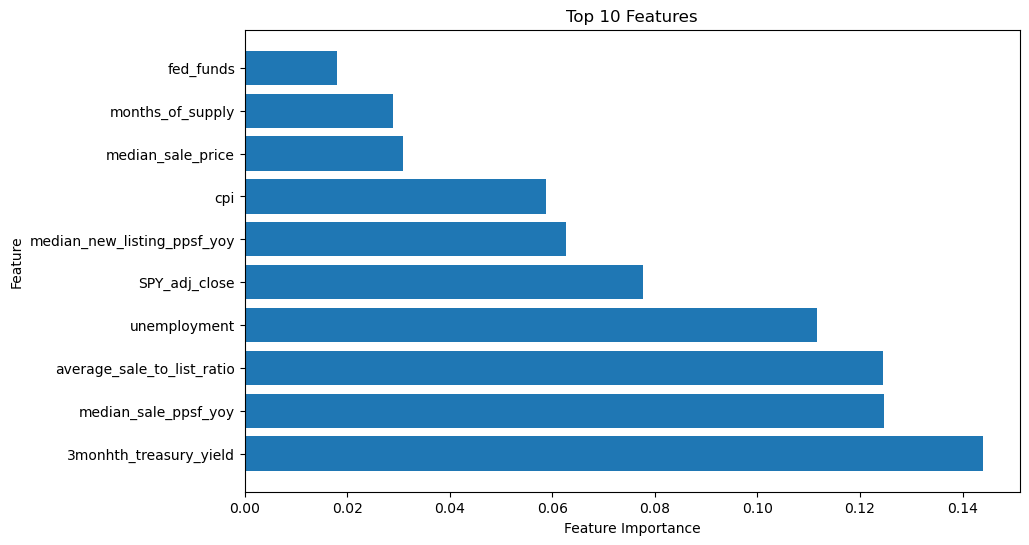

In [58]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(xgb_model.feature_importances_)[::-1][:10]],
         xgb_model.feature_importances_[np.argsort(xgb_model.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

#### Model Saving

In [59]:
# Save the model
pickle.dump(xgb_model, open('../models/EQR_xgb.pkl', 'wb'))

## Conclusion

In [60]:
models = ['Random Forest', 'AdaBoost', 'XGBoost']
predictions_train = [y_pred_rf_train, y_pred_ada_train, y_pred_xgb_train]
predictions_test = [y_pred_rf_test, y_pred_ada_test, y_pred_xgb_test]

utils.evaluate_models(models=models, predictions_train=predictions_train, predictions_test=predictions_test, X=X,
                      y_train=y_train, y_test=y_test, task='regression')

,,Random Forest,AdaBoost,XGBoost
Metric,Type,,,
Mean Absolute Error,Train,0.959358,3.27476,0.268645
Mean Squared Error,Train,1.566963,15.675373,0.122026
Root Mean Squared Error,Train,1.251784,3.959214,0.349323
R-squared,Train,0.983841,0.838353,0.998742
Adjusted R-squared,Train,0.981395,0.813878,0.998551
Mean Absolute Error,Test,5.08065,4.988588,4.750876
Mean Squared Error,Test,39.860562,35.856413,33.638143
Root Mean Squared Error,Test,6.313522,5.988022,5.79984
R-squared,Test,-0.073868,0.034006,0.093768
